### Для Google Colab: https://colab.research.google.com

from google.colab import files
uploaded = files.upload()

%%bash
yes | unzip seminar5.zip
mv -t . seminar5/*

<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE
## Семинар 5: регуляризация / аугментация / OpenCV
Иван Карпухин, ведущий программист-исследователь команды машинного зрения

<div style="clear:both;"></div>

Семинар состоит из двух частей. В первой мы применим классические методы регуляризации. Во второй сделаем аугментацию данных средствами OpenCV.

Для выполнения работы нужны следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision

Установить их можно командой:
```bash
pip3 install --user opencv-python torch torchvision
```

In [1]:
%matplotlib inline
import random

import cv2
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import cvmade
import seminar

print(torch.__version__)

# Параметры тренировки.
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Use CUDA")


TRAIN = True

TRAIN_KWARGS = {"plot": True,
                "train_plot_kwargs": {"c": "b"},
                "test_scatter_kwargs": {"c": "y", "s": 100, "zorder": 1e10},
                "use_cuda": USE_CUDA}

1.4.0+cpu


# Простая тренировка на CIFAR-10.

## Подготовка данных

Если возникнут трудности при загрузке данных, можно скачать архив по ссылке и самостоятельно распаковать в папку с ноутбуком, так, чтобы рядом с ноутбуком появилась папка cifar-10-batches-py.

Ссылка с данными (если не заработает автоскачивание): https://cloud.mail.ru/public/2ku1/KJPEsJ6xR

Extracting .\cifar-10-python.tar.gz to .
Files already downloaded and verified
Single image shape (CHW): [3, 32, 32]
Trainset size: 50000
Testset size: 10000
Trainset


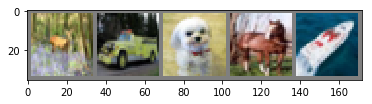

Testset


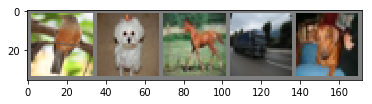

In [2]:
from torchvision.datasets import CIFAR10

DATA_ROOT = "."

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # Преобразовать PIL изображения в Torch тензоры.
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
trainset = CIFAR10(DATA_ROOT, train=True, download=True, transform=transform)
testset = CIFAR10(DATA_ROOT, train=False, download=True, transform=transform)
print("Single image shape (CHW):", list(testset[0][0].shape))
print("Trainset size:", len(trainset))
print("Testset size:", len(testset))

print("Trainset")
cvmade.plot.torch.show_images_dataset(trainset)
print("Testset")
cvmade.plot.torch.show_images_dataset(testset)

## Создание модели

Создадим сеть вида VGG (Сокращение от Visual Geometry Group, https://arxiv.org/pdf/1409.1556.pdf ).

Сеть VGG состоит из сверток 3x3, ReLU, max pooling и полносвязных слоев. Оригинальная сеть VGG применялась к изображениям 224x224, мы же применяем к изображениям 32x32. В статье описаны варианты сети VGG с количеством слоев от 11 до 19. Для задачи CIFAR10 достаточно меньшего числа слоев. Итоговая сложность модели позволит нам учить сеть на CPU.

Заметьте, что после pooling слоя площадь изображения уменьшается в 4 раза, а число каналов увеличивается в два раза, т.е. размер тензора уменьшается в два раза. Баланс между размером изображения и числом каналов позволяет сохранить достаточное количество информации при продвижении по сети.

<img src="resources/vgg1.jpg" align="left" hspace="20" width="50%" height="50%"/> 
<img src="resources/vgg2.jpg" align="left" hspace="20" width="50%" height="50%"/>
<div style="clear:both;"></div>

Шпаргалка:

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

torch.nn.ReLU(inplace=False)

torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

torch.nn.Linear(in_features, out_features, bias=True)
```

In [8]:
class VGGNetwork(torch.nn.Sequential):        
    def _make_conv3x3(self, in_channels, out_channels):
        # Начало вашего кода.
        
        layer = torch.nn.Conv2d(in_channels, out_channels, 3, stride=1, 
                                padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros')
        
        # Конец вашего кода.
        return layer
    
    def _make_relu(self):
        # Начало вашего кода.
        
        layer = torch.nn.ReLU(inplace=False)
        
        # Конец вашего кода.
        return layer
    
    def _make_maxpool2x2(self):
        # Начало вашего кода.
        
        layer = torch.nn.MaxPool2d(2, stride=None, padding=0, 
                                   dilation=1, return_indices=False, ceil_mode=False)
        
        # Конец вашего кода.
        return layer
    
    def _make_fully_connected(self, in_features, out_features, last=False):
        # Начало вашего кода.
        
        layer = torch.nn.Linear(in_features, out_features, bias=True)
        
        # Конец вашего кода.
        return layer
    
    def __init__(self, n_classes=10):
        # Мы используем same padding, чтобы свертки не меняли ширину и высоту тензоров.
        # Ширина и высота меняются только в maxpool (уменьшаются в два раза).
        layers = [
            self._make_conv3x3(in_channels=3, out_channels=32),
            self._make_conv3x3(in_channels=32, out_channels=32),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            self._make_conv3x3(in_channels=32, out_channels=64),
            self._make_conv3x3(in_channels=64, out_channels=64),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            self._make_conv3x3(in_channels=64, out_channels=128),
            self._make_conv3x3(in_channels=128, out_channels=128),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            self._make_conv3x3(in_channels=128, out_channels=256),
            self._make_conv3x3(in_channels=256, out_channels=256),
            self._make_relu(),
            self._make_maxpool2x2(),
            
            torch.nn.modules.Flatten(),  # Преобразовать 4-мерный тензор BHWC в двумерный BD.
            
            self._make_fully_connected(in_features=256 * 2 * 2, out_features=512),
            self._make_fully_connected(in_features=512, out_features=512),
            self._make_fully_connected(in_features=512, out_features=n_classes, last=True)
        ]
        super().__init__(*layers)
        self.initialize_weights()
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)
                
vgg = VGGNetwork()
print(vgg)

seminar.check_vgg(VGGNetwork)

VGGNetwork(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16): 

## Обучение

Воспользуемся оптимизацией с моментом Нестерова. Будем использовать момент, равный 0.9 и начальный шаг обучения 0.01.

Шпаргалка:

```python
torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')

torch.optim.SGD(params, lr, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```

In [13]:
def make_loss():
    # Ваш код, который создает loss.
    
    loss = torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
    
    #
    return loss

def make_optimizer(model):
    # Ваш код, который создает оптимизатор.
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, dampening=0, weight_decay=0, nesterov=True)
    
    # Конец вашего кода.
    
    return optimizer

seminar.check_loss_fn(make_loss)
seminar.check_optimizer_fn(make_optimizer)

CHECK OK
CHECK OK


Используем экспоненциально затухающий learning rate.

График изменения learning rate:


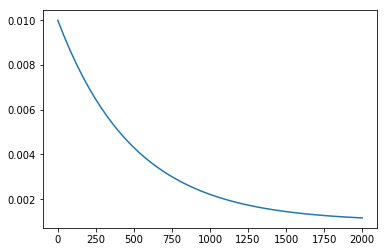

In [12]:
def lr(step):
    return 0.1 + 0.9 * (0.998) ** step

def make_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

xs = np.linspace(0, 2000)
print("График изменения learning rate:")
plt.plot(xs, 0.01 * lr(xs))
plt.show()

<IPython.core.display.Javascript object>


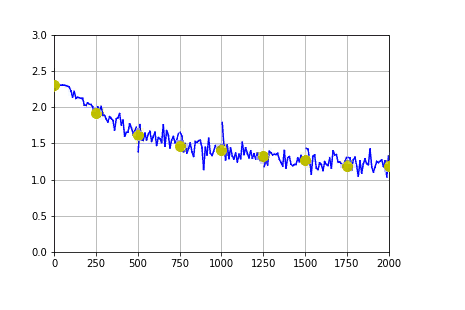

Test loss: 2.302681803894043
Test accuracy: 0.1019
Step 0
Train loss: 2.0226, learning rate: 0.0065         
Test loss: 1.9131270011901855
Test accuracy: 0.2648
Step 250
Train loss: 1.7106, learning rate: 0.0043         
Test loss: 1.6122268306732177
Test accuracy: 0.3912
Step 500
Train loss: 1.4635, learning rate: 0.0030         
Test loss: 1.4658495226860047
Test accuracy: 0.4484
Step 750
Train loss: 1.3716, learning rate: 0.0022         
Test loss: 1.4005862672805787
Test accuracy: 0.4875
Step 1000
Train loss: 1.2925, learning rate: 0.0017         
Test loss: 1.3201713921546936
Test accuracy: 0.5108
Step 1250
Train loss: 1.2424, learning rate: 0.0014         
Test loss: 1.2741457333564759
Test accuracy: 0.5336
Step 1500
Train loss: 1.1826, learning rate: 0.0013         
Test loss: 1.1870251052856444
Test accuracy: 0.5759
Step 1750
Train loss: 1.3331, learning rate: 0.0012         
Test loss: 1.1796586304664611
Test accuracy: 0.57


In [15]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer, trainset, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/01-simple-train.jpg")

In [16]:
TRAIN = False

# Batchnorm

Batchnorm ( https://arxiv.org/pdf/1502.03167.pdf ) это техника улучшения сходимости сетей с большим количеством слоёв.

Во время тренировки:

<img src="resources/batchnorm.jpg" align="left" width="40%" height="40%"/> 
<div style="clear:both;"></div>

Во время применения статистики по батчу заменяются на более точные статистики по корпусу данных.

Шпаргалка:

```python
torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
```

In [17]:
class VGGNetworkBN(VGGNetwork):
    @staticmethod
    def _make_conv3x3(in_channels, out_channels):
        
        # Ваш код, который создает слои сети.
        
        conv_layer = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        batchnorm_layer = torch.nn.BatchNorm2d(out_channels)
        
        # Конец вашего кода.
        return torch.nn.Sequential(conv_layer, batchnorm_layer)
    
vgg_bn = VGGNetworkBN()
print(vgg_bn)
seminar.check_vgg_bn(VGGNetworkBN)

VGGNetworkBN(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

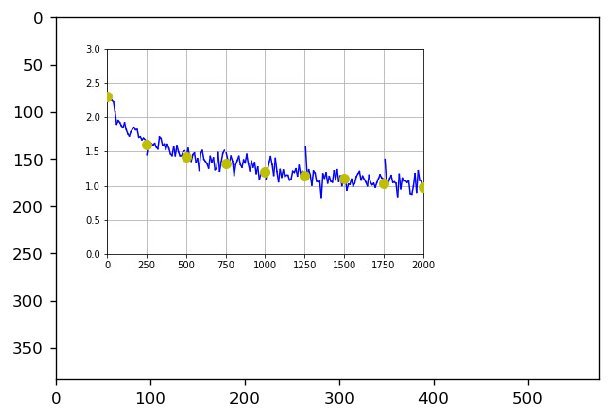

In [18]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/02-batchnorm.jpg")

# Переобучение

Из соображений производительности, мы используем небольшую сеть. На CIFAR10 она не переобучается. Чтобы воспроизвести ситуацию с переобучением, мы уменьшим количество тренировочных данных.

In [19]:
TRAIN_SUBSET_SIZE = 5000

trainset_small_indices = random.sample(list(range(len(trainset))), TRAIN_SUBSET_SIZE)
trainset_small = torch.utils.data.Subset(trainset, trainset_small_indices)
print("Small trainset size:", len(trainset_small))

Small trainset size: 5000


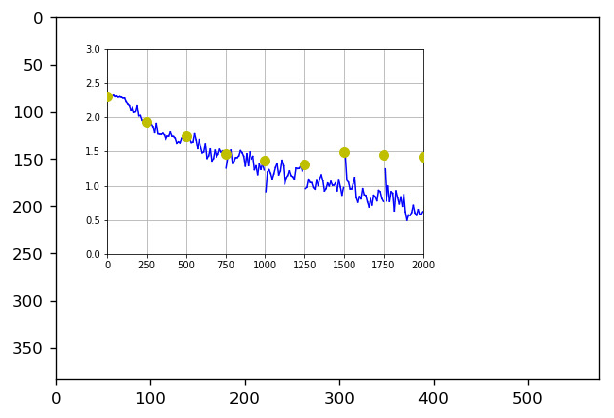

In [20]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/03-overfit.jpg")

## L2 - регуляризация (Тихонова)

К функции потерь добавляется сумма квадратов параметров модели с некотрым весом (weight decay). В итоге модель штрафуется за слишком большие веса модели. Ограничение на диапазон значений параметров приводит к уменьшению переобучения.

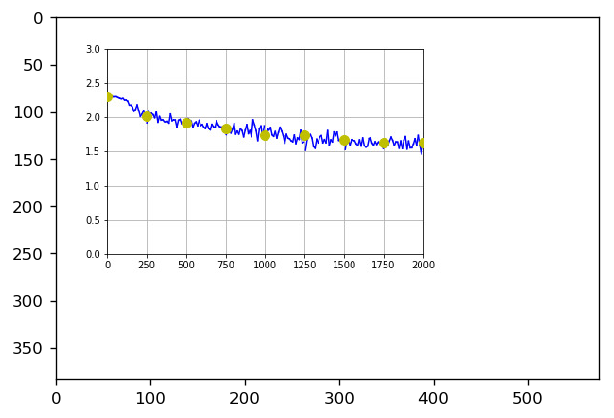

In [21]:
WEIGHT_DECAY = 0.01

def make_optimizer_l2_reg(model):
    return torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=WEIGHT_DECAY)

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg, make_loss, make_optimizer_l2_reg, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/04-l2.jpg")

# Dropout

Свертки содержат мало параметров, они не переобучаются. По-этому, dropout обычно используют в полносвязных слоях.

In [22]:
class VGGNetworkDO(VGGNetwork):
    @staticmethod
    def _make_fully_connected(in_features, out_features, last=False):
        layers = [torch.nn.Linear(in_features, out_features)]
        if not last:
            layers.append(torch.nn.Dropout(p=0.85))
        return torch.nn.Sequential(*layers)
    
vgg_do = VGGNetworkDO()
print(vgg_do)
seminar.check_vgg_do(VGGNetworkDO)

VGGNetworkDO(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (16)

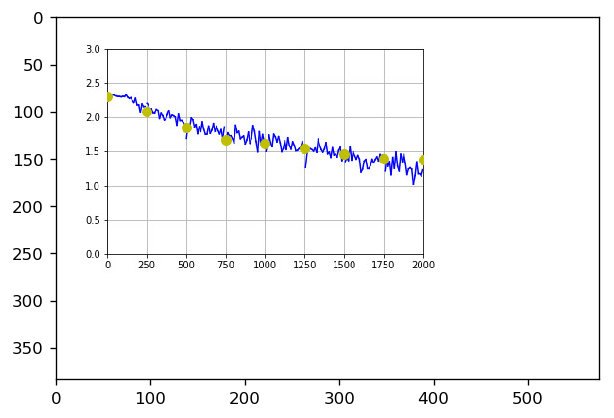

In [23]:
if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_do, make_loss, make_optimizer, trainset_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/05-dropout.jpg")

## Аугментация

Мы используем следующие аугментации:
1. Rotation / Scale / Offset
2. Random crop
3. Brightness / Contrast
4. Blur

### Смещения и повороты

Шпаргалка:
```python
cv2.getRotationMatrix2D(center, angle, scale)  # center: (x, y), angle: градусы, scale: число.

cv2.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])
```

Files already downloaded and verified


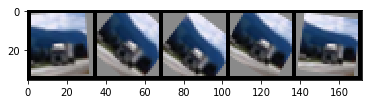

In [27]:
# Если scale == 1, то изображение не масштабируется, если <1 - уменьшается, >1 - увеличивается.
# min_scale, max_scale: диапазан, из которого выбирается случайный коэффициент масштабирования.

# Если offset == 0, то изображение не смещается.

class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_scale=1.1, max_offset=0.1):
        self._min_scale = min_scale
        self._max_scale = max_scale
        self._max_offset = max_offset
    
    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        
        angle = random.random() * 90 - 45
        scale = self._min_scale + random.random() * (self._max_scale - self._min_scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        
        # Ваш код, который преобразует изображение используя угол angle,
        # масштаб scale и смещение (x_offset, y_offset). Фон предлагается закрасить серым цветом.
        
        # Начало вашего кода.
        
        transform = cv2.getRotationMatrix2D((w//2, h//2), angle, scale)
        transform[:,2] += [x_offset, y_offset]
        new_image = cv2.warpAffine(image, transform, (w,h), borderValue=(128, 128, 128))
        
        # Конец вашего кода.
        
        return Image.fromarray(new_image)  # Numpy -> PIL.
  
%matplotlib inline
seminar.show_augmenter_results(AffineAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-00-affine.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

Files already downloaded and verified
Trainset size: 5000


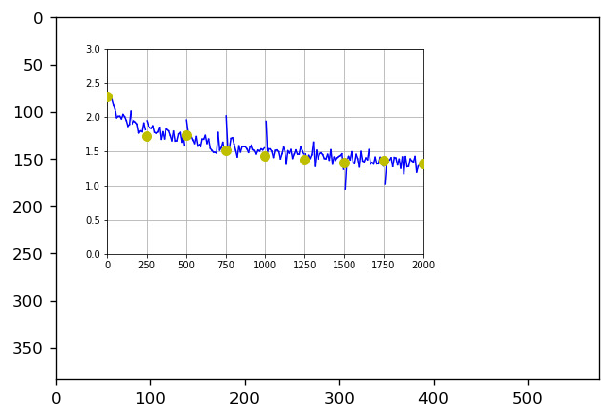

In [28]:
augmentation_transform = torchvision.transforms.Compose([
    AffineAugmenter(),
    transform
])
trainset_augmented_small = torch.utils.data.Subset(
    CIFAR10(DATA_ROOT, train=True, download=True, transform=augmentation_transform),
    trainset_small_indices)
print("Trainset size:", len(trainset_augmented_small))

if TRAIN:
    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/07-aug-affine.jpg")

### Случайный подкадр

Шпаргалка:
```(python)
cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])
```

Files already downloaded and verified


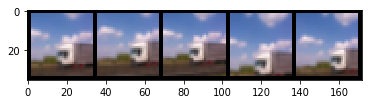

In [31]:
class CropAugmenter(object):
    def __init__(self, min_scale=0.8):
        self._min_scale = min_scale
    
    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        new_w = int(scale * w)
        new_h = int(scale * h)
        x = random.randint(0, w - new_w)
        y = random.randint(0, h - new_h)
        
        # Ваш код, который создает изображение new_image с фрагментом изображения image, 
        # который задается смещением (x, y) и размером (new_w, new_h).
        
        # Начало вашего кода.
        
        new_image = cv2.resize(image[y:y + new_h, x:x + new_w], (w,h))
    
        # Конец вашего кода.
        
        return Image.fromarray(new_image)  # Numpy -> PIL.

%matplotlib inline
seminar.show_augmenter_results(CropAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-01-crop.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

### Изменение яркости и контраста

Изменение яркости, это добавление значения ко всем каналам изображения. Если добавляется число больше 0, то яркость увеличивается, если меньше 0, то уменьшается.

Изменение контраста, это растяжение диапазона значений цветов. Изменение контраста не изменяет серого цвета.

Будьте внимательны. Изображение хранится в формате uint8, возможно переполнение. Перед преобразованием изображение можно перевести во float32, а после обрезать диапазон значений и вернуть изображение в uint8.

Шпаргалка:
```python
np.clip(a, a_min, a_max)
```

Files already downloaded and verified


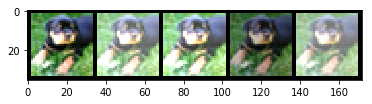

In [40]:
class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast
    
    def __call__(self, image):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        
        # Ваш код, который применяет яркость brightness и контраст contrast.
        
        new_image = image.astype(np.float32)
        new_image = (new_image - 128) * contrast + 128
        new_image = new_image + brightness * 255
        new_image = np.clip(new_image, 0, 255).astype(np.uint8)
                     
        # Конец вашего кода.
        
        assert new_image.dtype == np.uint8
        return Image.fromarray(new_image)  # Numpy -> PIL.
    
%matplotlib inline
seminar.show_augmenter_results(BrightnessContrastAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-02-color.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

### Размытие

Фотографии часто имеют естественное размытие. Можно моделировать размытие используя сглаживание. Мы используем размытие с фильтром Гаусса. Он параметризуется размером фильтра (в пикселях) и величиной размытия sigma в пикселях, которая совпадает со стандартным отклонением распределения Гаусса.

Шпаргалка:
    
```(python)
cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])  # ksize: (w, h), sigmaX: число.
```

Files already downloaded and verified


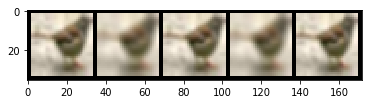

In [42]:
class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel
    
    def __call__(self, image):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        
        # Начало вашего кода.
        
        new_image = cv2.GaussianBlur(image, (kernel, kernel), kernel //2)
        
        # Конец вашего кода.
        return Image.fromarray(new_image)  # Numpy -> PIL.
    
%matplotlib inline
seminar.show_augmenter_results(BlurAugmenter(), DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-03-blur.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

### Комбинация аугментаций

Files already downloaded and verified


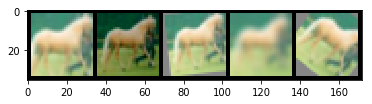

In [43]:
class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)
        
    def __call__(self, image):
        augmenter = random.choice(self._augmenters)
        return augmenter(image)
    
augmenter = RandomAugmentation(AffineAugmenter(),
                               CropAugmenter(),
                               BrightnessContrastAugmenter(),
                               BlurAugmenter())
%matplotlib inline
seminar.show_augmenter_results(augmenter, DATA_ROOT)

Пример:
<div style="clear:both;"></div>
<img style="float: left;" src="resources/aug-04-random.jpg" width="40%" height="40%">
<div style="clear:both;"></div>

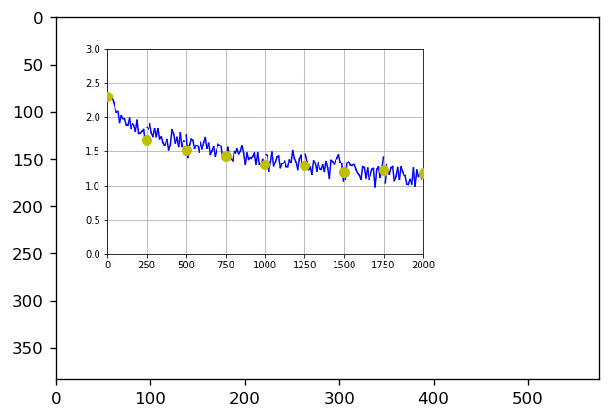

In [44]:
if TRAIN:
    augmentation_transform = torchvision.transforms.Compose([
        augmenter,
        transform
    ])
    trainset_augmented_small = torch.utils.data.Subset(
        CIFAR10(DATA_ROOT, train=True, download=True, transform=augmentation_transform),
        trainset_small_indices)
    print("Trainset size:", len(trainset_augmented_small))

    # Разрешить интерактивные графики.
    %matplotlib notebook
    seminar.train_model(vgg_bn, make_loss, make_optimizer, trainset_augmented_small, testset,
                        lr_scheduler_fn=make_lr_scheduler,
                        **TRAIN_KWARGS)
    # Отключить интерактивные графики.
    %matplotlib inline
else:
    %matplotlib inline
    cvmade.plot.show_image("resources/08-aug-all.jpg")